In [15]:
import geopandas as gpd
import fiona
import osmnx as ox
import folium
from fiona.model import to_dict
from shapely.geometry import shape
from branca.colormap import LinearColormap
import numpy as np
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
from scipy.spatial import Voronoi,voronoi_plot_2d
from geovoronoi import voronoi_regions_from_coords, points_to_coords
import random
from shapely.geometry import Polygon, Point

from skmob.tessellation.tilers import tiler
from skmob.utils.plot import plot_gdf
import requests
import pyproj
from shapely.ops import transform

In [16]:
tess_squared = tiler.get('squared', base_shape='Leuven, Belgium', meters=1000)
def get_convex_hull(tess):
    polygon = tess.at[0, 'geometry']
    for tile in tess['geometry']:
        polygon = polygon.union(tile)
    return polygon.convex_hull

poly_ch = get_convex_hull(tess_squared)

In [17]:
def Leuven_map():
    point = (50.849738563227824, 4.644786576420597)
    m = folium.Map(location=point, zoom_start = 12)
    return m

# DATA

In [18]:
zones_leuven = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/socio_demographic_data/leuven_statsec.gpkg')
zones_leuven = zones_leuven.to_crs('epsg:4326')
zones_leuven.reset_index(inplace=True)

In [19]:
# ciclabile/strada
cyclic = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/cycling_data/cycling_network.gpkg')
cyclic = cyclic.to_crs(epsg=4326)
nan_length = list(np.where(cyclic['LENGTE'].isna())[0])
cyclic.drop(nan_length, axis = 0, inplace = True)
cyclic.reset_index(inplace = True,  drop = True)

In [20]:
#info socio-dem
socio_dem_data = pd.read_excel('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/socio_demographic_data/socio_demographic_data_leuven_2019.xlsx')
#drop nan zone
socio_dem_data.drop(np.where(socio_dem_data['CODSEC'].isna())[0][0], axis = 0 ,inplace=True)

In [21]:
#ciclabili per le zone selezionate
ind = set()
for i in range(len(cyclic)):
    z = zones_leuven['geometry']
    s = np.where(z.intersects(cyclic['geometry'][i]))[0]
    if len(s) > 0:
        ind.add(i)

In [22]:
leuven_cyclic = cyclic.iloc[list(ind), :]
utm = leuven_cyclic.estimate_utm_crs()
project = pyproj.Transformer.from_crs('4326', utm)

In [23]:
# off_street_parking
url = 'https://storageaccount11111111.blob.core.windows.net/container1/Leuven/parking_data_leuven/off_street_parking_supply_Leuven.json'
response = requests.get(url)
json_data = response.json()

results = json_data['JSON']['results']
normalized_data = pd.json_normalize(results)

df = pd.DataFrame(normalized_data)

In [24]:
# estraggo info dalla colonna bullets 
spots = []
cameras = []
accessibility = []
lift = []
height = []


for row in df['bullets']:
    spot_number = None
    camera_label = None
    accessibility_label = None
    lift_label = None
    height_label = None
    
    for item in row:
        label = item['label']
        if 'spots' in item['icon']:
            spot_number = int(''.join(filter(str.isdigit, label)))
        elif 'camera' in item['icon']:
            camera_label = label
        elif 'accessibility' in item['icon']:
            accessibility_label = label
        elif 'lift' in item['icon']:
            lift_label = label
        elif 'height' in item['icon']:
            height_label = label
    

    spots.append(spot_number)
    cameras.append(camera_label)
    accessibility.append(accessibility_label)
    lift.append(lift_label)
    height.append(height_label)

df['spots'] = spots
df['cameras'] = cameras
df['accessibility'] = accessibility
df['lift'] = lift
df['height'] = height

df = df.drop('bullets', axis=1)

In [25]:
geometry = [Point(xy) for xy in zip(df['coords.lng'], df['coords.lat'])]
off_parkings = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

columns_subset = ['pricing_type', 'free_bus', 'id', 'subtype', 'spots', 'lift', 'geometry']
off_parkings = off_parkings[columns_subset]
mapping = {'None': 0, 'Parking met lift': 1, True: 1, False:0}
off_parkings['lift'] = off_parkings['lift'].replace(mapping)
off_parkings['free_bus'] = off_parkings['free_bus'].replace(mapping)
off_parkings['lift'] = off_parkings['lift'].fillna(0)
off_parkings.shape

(43, 7)

In [26]:
on_street = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/parking_data/onstreet_parking_Leuven_2023.gpkg')
on_street = on_street.to_crs(epsg='4326')

In [27]:
stops = pd.read_csv('stops.csv')

In [28]:
coords = []
for index, rows in stops.iterrows():
    coords.append(Point(rows['stop_lon'], rows['stop_lat'],))

coords = gpd.GeoDataFrame(geometry=coords, crs = 'EPSG:4326')
coords['id'] = stops['stop_id']

In [29]:
#stops per le zone selezionate
ind = set()
for i in range(len(coords)):
    z = zones_leuven['geometry']
    s = np.where(z.contains(coords['geometry'][i]))[0]
    if len(s) > 0:
        ind.add(i)

In [30]:
leuven_stops = coords.iloc[list(ind), :]
leuven_stops.reset_index(inplace=True, drop = True)

In [31]:
import geopy.distance

In [32]:
utm_coords = leuven_stops.to_crs(utm)

In [33]:
utm_coords.reset_index(inplace = True, drop = True)

In [34]:
m = Leuven_map()
for ind, row in leuven_stops.iterrows():
    folium.Marker(row['geometry'].coords[0][::-1], popup=f"<id>{row['id']}").add_to(m)

In [35]:
ind = set()
for i,v in utm_coords.iterrows():
    if i not in ind:
        dist_arr = np.array(v['geometry'].distance(utm_coords['geometry']))
        low_arr = set(np.where(dist_arr < 60)[0])
        zero_dist = set(np.where(dist_arr == 0)[0])
        if len(zero_dist) > 0:
            low_arr = low_arr.difference(zero_dist)
        ind.update(low_arr)

In [36]:
ridotto = leuven_stops.drop(ind, axis = 0)
ridotto.reset_index(inplace=True, drop = True)
ridotto_utm = ridotto.to_crs(utm)

cyclic distance

In [37]:
cyclic['id'] = list(range(len(cyclic)))

start = []
end = []
geom = []

for i in cyclic['id']:  
    start.append(cyclic['geometry'][i].coords[0])
    end.append(cyclic['geometry'][i].coords[-1])
    
cyclic['start'] = start
cyclic['end'] = end
#dict key:coordinate - value:id
nodes = list(set(start).union(set(end)))
nodes.sort()
for point in nodes:
    geom.append(Point(point))

nodes_dict = {}
id_nodes = {}
for node in nodes:
    nodes_dict['id'] = nodes_dict.get('id', []) + [nodes.index(node)]
    nodes_dict['x']= nodes_dict.get('x', []) + [node[0]]
    nodes_dict['y']= nodes_dict.get('y', []) + [node[1]]

    id_nodes[(node[0], node[1])] = nodes.index(node)

    
cyclic_nodes = gpd.GeoDataFrame(nodes_dict, crs='epsg:4326', geometry= geom )

edges = {}

for i in cyclic['id']:
    edges['u'] = edges.get('u', []) + [id_nodes[cyclic['start'][i]]]
    edges['v'] = edges.get('v', []) + [id_nodes[cyclic['end'][i]]]
    edges['geometry'] = edges.get('geometry', []) + [cyclic['geometry'][i]]
    edges['length'] = edges.get('length', []) + [cyclic['LENGTE'][i]]
    edges['key'] = edges.get('key', []) + [i]

cyclic_edges = gpd.GeoDataFrame(edges, crs='epsg:4326')
cyclic_edges = cyclic_edges.set_index(['u', 'v', 'key'])
G = ox.graph_from_gdfs(cyclic_nodes, cyclic_edges)

G = nx.to_undirected(G)

# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
lon, lat = (4.70053, 50.87984)
center_node = ox.nearest_nodes(G, X=lon, Y = lat)
G.nodes[center_node]

{'id': 2674, 'x': 4.70053984670537, 'y': 50.8798258193953}

In [38]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = 8.5 * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

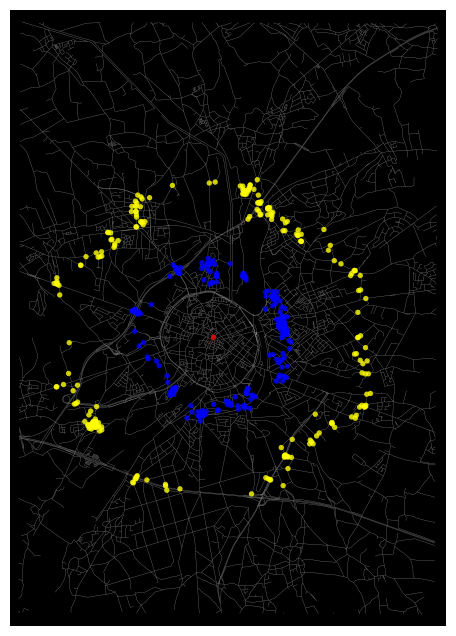

In [39]:
# color the nodes according to isochrone then plot the street network
distances = [15, 30]
node_colors = {}
node_found = []
color = {15:'blue', 30:'yellow', 45:'green'}

subgraph = nx.ego_graph(G, center_node, radius=30000, distance = 'time')
for time in distances:
    n = []
    for node in subgraph.nodes():
        w = nx.shortest_path_length(subgraph, center_node, node, weight= 'time')
        if time-1.5 <= w <= time+0.5:
            n.append(node)
            node_colors[node] = color[time]
        if node == center_node:
            node_colors[node] = 'red'

    node_found.append(n)

nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999')



In [40]:
ch = []
for dist in node_found:
    points = []
    for point in dist:
        points.append(Point(G.nodes[point]['x'], G.nodes[point]['y']))
    points = gpd.GeoDataFrame(geometry = points)
    ch.append(get_convex_hull(points))

ch[1] = ch[1].difference(ch[0])

## calcolo distanze tra :

In [55]:
transformed_parkings = off_parkings.to_crs(utm)
transform_cyclic = leuven_cyclic.to_crs(utm)
transformed_onstreet = on_street.to_crs(utm)

transform_cyclic.reset_index(inplace = True, drop = True)
leuven_cyclic.reset_index(inplace=True,  drop = True)

w_offpark = 3
w_onpark = 3
w_bike = 0.5
w_bus = 2
w_incomm = 0.5
w_outcomm = 0.5
w_total = 0.5
w = [w_offpark, w_onpark, w_bike, w_bus ,w_incomm, w_outcomm, w_total]

In [59]:
def get_score(index, row):
    candidate = row['geometry']
    feat = {}
    #distance from off-street parking
    feat['nearest_offpark'] = 1/(np.min(candidate.distance(transformed_parkings['geometry']))+1e-6) #penalize higher distances
    #distance from off-street parking
    feat['nearest_onpark'] = 1/(np.min(candidate.distance(transformed_onstreet['geometry']))+1e-6) #penalize higher distances
    #distance from center by bike 
    if ch[0].contains(leuven_cyclic['geometry'][index]):
        dist_bike = 1
    elif ch[1].contains(leuven_cyclic['geometry'][index]):
        dist_bike = 2
    else:
        dist_bike = 3
    feat['distance_bike'] = dist_bike
    #bus stops
    feat['nearest_bus'] = 1/np.min(candidate.distance(ridotto_utm['geometry']))
    #find the city zone of the candidate street
    zona = np.where(candidate.intersects(zones_leuven['geometry'].to_crs(utm)))[0][0]
    #retrieve demographic information
    code = zones_leuven['CODSEC'][zona]
    feat['total_citizens'] = float(socio_dem_data[socio_dem_data['CODSEC'] == code]['total_citizens'])
    feat['outg_commuters'] =float(socio_dem_data[socio_dem_data['CODSEC'] == code]['outg_commuters'])
    feat['inc_commuters'] =float(socio_dem_data[socio_dem_data['CODSEC'] == code]['inc_commuters'])
    #penalize candidate near hubs


    return np.dot(w,list(feat.values()))

eps = 0.1

def update_scores(scores, new_hub):
    new_scores = []
    new_hub = transform_cyclic.iloc[new_hub[0], :]
    for idx, score in scores:
        candidate = transform_cyclic.iloc[idx, :]
        distance = candidate['geometry'].distance(new_hub['geometry'])
        print(eps * 1/(distance + 1e-6))
        score = score - eps * 1/(distance + 1e-6)
        new_scores.append([idx, score])
    return new_scores

In [58]:
hubs = []
n_hub = 10

#candidate ranking
scores = []
for idx, row in transform_cyclic.iterrows():
    scores.append([idx, get_score(idx, row)])


In [44]:
while n_hub > 0:
    #sort scores by ranking
    scores = sorted(scores, key=lambda x:x[1], reverse= True)  
    #add candidate id highest score
    hubs.append(scores[0])
    n_hub-=1
    #update rankings
    scores = update_scores(scores, hubs[-1])
    


771 2732.6676641582308
100000.00000000001
2900 2728.588158855484
100000.00000000001
1794 2728.0983641404778
0.00015019608861833458
1792 2727.6480192960553
0.00015019608861833458
717 2727.621668280351
0.00015342491864800612
4134 2727.6197191021265
0.00015060474759439734
2350 2727.612960990564
0.0001138489198787889
2546 2727.2713159713667
100000.00000000001
1785 2727.129850535928
0.00013209174603095704
923 2727.1255843237464
0.00011099323047873626
4056 2727.1233217048393
0.00013209174603095704
2715 2727.122531647482
0.0001452729018585166
2262 2727.1168617778576
0.00010899985936428829
1760 2727.1139226963232
0.0001097244124082626
3634 2727.1139056731135
0.00010899985936428829
1761 2727.112866340763
0.0001090454216977369
3603 2727.112794917937
0.0001097244124082626
1763 2727.1125615076257
0.00011162655877990035
350 2727.1125089835123
0.00010579730845052576
351 2727.1113492489285
0.00011180721842897267
1724 2727.1113492489285
0.00011180721842897267
3662 2727.0374657412276
0.0001478647016967

In [45]:
hubs

[[771, 2732.6676641582308],
 [1794, 2728.098213944389],
 [4134, 2727.6184525562285],
 [717, 2727.6132379017486],
 [2350, 2727.6038522528893],
 [1785, 2727.1261918417295],
 [923, 2727.1231168850213],
 [3634, 2727.1103624719553],
 [3603, 2727.105827582089],
 [350, 2727.0918601730123]]

In [49]:
hubs_ids = [t[0] for t in hubs]
m = Leuven_map()
folium.GeoJson(on_street).add_to(m)